# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: |   Tony | Chuwa|Tony Peter Chuwa 08/11/2024 | 9 Hours | 25% |
| Member 2: | Gagan | Kataria | Gagan Kataria 08/11/2024 |  8 Hours |  25% |
| Member 3: | Augitustine | Ikechukwu | Augustine Ikechukwu Ojumah 08/11/2024 |8 Hours | 25%  |
| Member 4: | Abraham | Tesfamichael |  Abraham Yihdego Tesfamichael 08/11/2024 | 8 Hours | 25%  |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

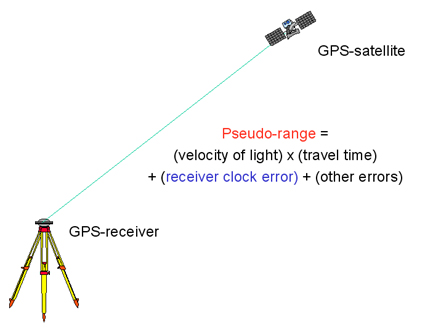

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


In [4]:
!ls

 Assignment3.pptx	   'Introduction to Machine Learning.ipynb'   satellite_position1.xlsx
 ENGG680_Lab3_F24_L01.pdf   pseudoranges1.xlsx			     'Table of Contents.html'


In [5]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [6]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [7]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

print("arr_cost:", arr_cost)
print("arr_grad:", arr_grad)
print("arr_err:", arr_err)
print("steps_count:", steps_count)

arr_cost: []
arr_grad: []
arr_err: []
steps_count: 0


Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [8]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance
print(euclidean_norm(GroundTruth, sat_pos))

[22919735.50416796 20459891.58181501 22400334.25542599 22829138.20273155
 22342011.77899318 25646450.14718576 23814770.16593441 24311391.26510924
 21353638.3890343  24971604.82362354 20638980.11687546]


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [9]:
# Define the cost function
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distance using the euclidean_norm function
    geometric_dist = euclidean_norm(r_pos, s_pos)

    # Calculate the predicted pseudorange
    predicted_pseudorange = geometric_dist + cdT

    # Calculate residuals between observed and predicted pseudoranges
    residuals = pseudorange - predicted_pseudorange

    # Compute the sum of squared residuals
    cost = np.sum(residuals**2)

    return cost


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [10]:
# Define the gradient computation function
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distance using the euclidean_norm function
    geometric_dist = euclidean_norm(r_pos, s_pos)

    # Calculate the predicted pseudorange
    predicted_pseudorange = geometric_dist + cdT

    # Calculate residuals between observed and predicted pseudoranges
    residuals = pseudorange - predicted_pseudorange

    # Add a small constant to avoid division by zero
    epsilon = 1e-8

    # Compute the partial derivatives with respect to x_r, y_r, z_r
    dL_dx = -2 * np.sum((residuals * (r_pos[0] - s_pos[:, 0])) / (geometric_dist + epsilon))
    dL_dy = -2 * np.sum((residuals * (r_pos[1] - s_pos[:, 1])) / (geometric_dist + epsilon))
    dL_dz = -2 * np.sum((residuals * (r_pos[2] - s_pos[:, 2])) / (geometric_dist + epsilon))

    # Compute the partial derivative with respect to cdT
    dL_dcdT = -2 * np.sum(residuals)

    # Return the gradient as a 1D numpy array
    return np.array([dL_dx, dL_dy, dL_dz, dL_dcdT])



### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [11]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [14]:
optimized_params = #...

# print the mentioned metrics
# ...

# ...

In [21]:
# Function to compute the Euclidean distance between the receiver and satellites
def euclidean_norm(receiver_pos, satellite_pos):
    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis=1)
    return distance


In [22]:
# Call the gradient_descent function to optimize parameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Compute the final position error of the receiver
final_position_error = np.linalg.norm(optimized_params[:3] - GroundTruth)

# Compute the final cost value
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

# Compute the final gradient
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

# Print the required results
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Error (m):", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)


Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-0.81019529 -2.0086973   0.32496446 -2.68914603]
Final Position Error (m): 6366295.806025339
Number of Steps Taken for Convergence: 51468
Final Cost Value: 1.037974622571048
Final Gradient Values: [ 0.02409219  0.0676956  -0.03113526  0.06218636]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

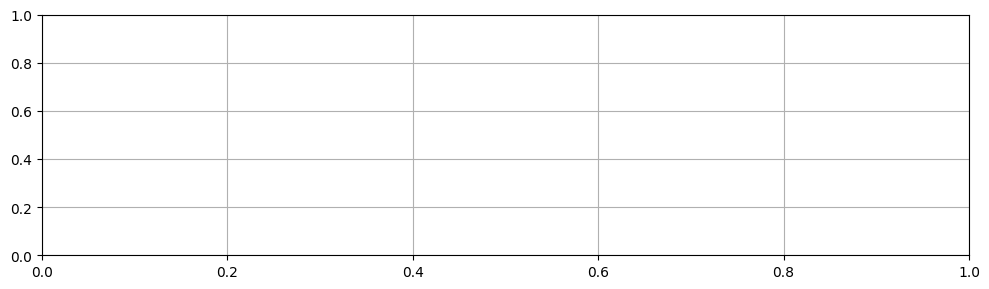

In [23]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

Converged!


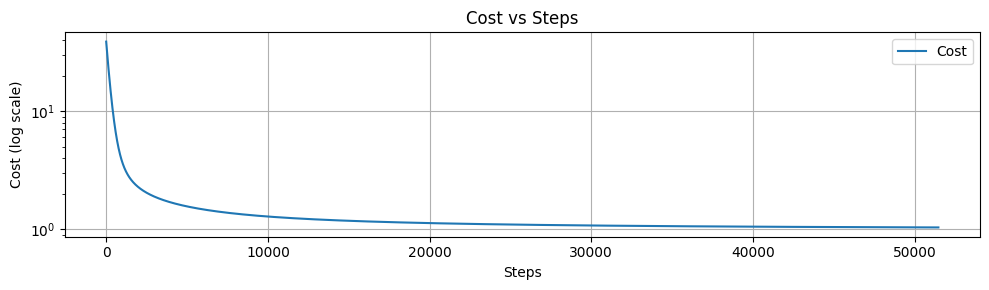

In [24]:
# Normalizing satellite positions
sat_pos = (sat_pos - np.mean(sat_pos, axis=0)) / np.std(sat_pos, axis=0)

# Normalizing pseudoranges
pseudorange = (pseudorange - np.mean(pseudorange)) / np.std(pseudorange)

# Gradient descent algorithm with gradient clipping and checks
def gradient_descent(pseudorange, s_pos, learning_rate=0.0001, max_iters=100000, tolerance=1e-6):
    global arr_cost, steps_count
    arr_cost = []
    steps_count = 0
    X = np.random.uniform(-1e-3, 1e-3, size=4)  # Initializing with small random values

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        grad = gradient(r_pos, cdT, s_pos, pseudorange)
        grad = np.clip(grad, -1e3, 1e3)  # Clip gradients to prevent overflow

        # Check for NaN or Inf in gradients
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Iteration {iteration}: Gradient has NaN or Inf values. Stopping optimization.")
            break

        X_new = X - learning_rate * grad
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        arr_cost.append(current_cost)

        if np.abs(new_cost - current_cost) < tolerance:
            steps_count = iteration
            print("Converged!")
            break

        X = X_new

    return X

# Run the gradient descent function with the normalized data
optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.0001)

# Plot cost vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.semilogy(arr_cost, label='Cost')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (log scale)')
ax.set_title('Cost vs Steps')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern:
# The "Cost vs Steps" plot should shows a decreasing trend, indicating that the gradient descent is reducing the cost.
# And the plot shows a smooth decrease that levels off towards the end because the optimization has converged.


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

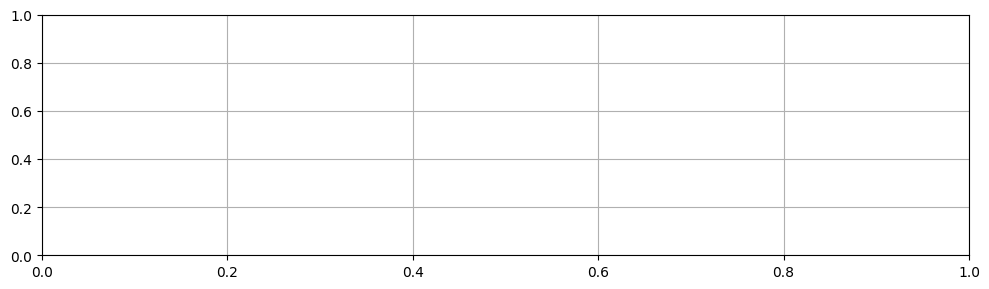

In [25]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

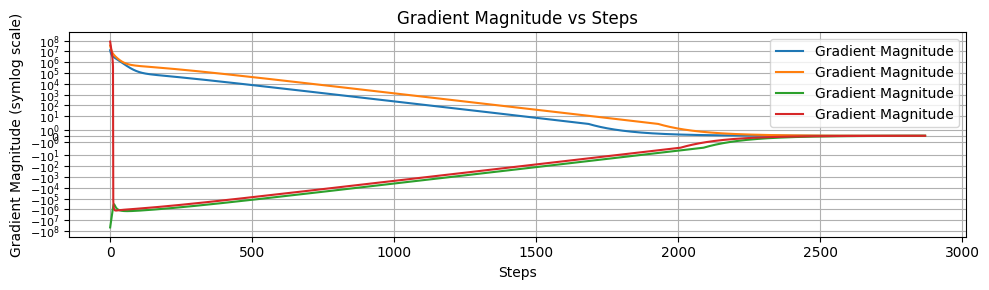

In [26]:
# Plot gradient magnitudes vs steps using 'symlog' for scaling the y-axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_grad, label='Gradient Magnitude')
ax.set_yscale('symlog')  # Use symmetric logarithmic scale for the y-axis
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Magnitude (symlog scale)')
ax.set_title('Gradient Magnitude vs Steps')
ax.tick_params(axis='y', labelsize=8)  # Set y-axis label size
ax.grid(True)  # Add grid lines for better visualization
ax.legend()

fig.tight_layout()  # Adjust the layout to prevent clipping of labels
plt.show()

# Comment on the pattern:
# The "Gradient Magnitude vs Steps" plot shows a decreasing trend in gradient magnitude as the number
# of steps increases, indicating that the gradient descent algorithm is converging. Initially, the gradients
# are larger, reflecting substantial updates in the early iterations. As the number of steps increases,
# the gradient magnitudes decrease, indicating that the updates are becoming smaller, and the algorithm
# is approaching convergence. If the gradient magnitudes stabilize and approach zero, this suggests that
# the optimization process has reached a minimum or is close to it.


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

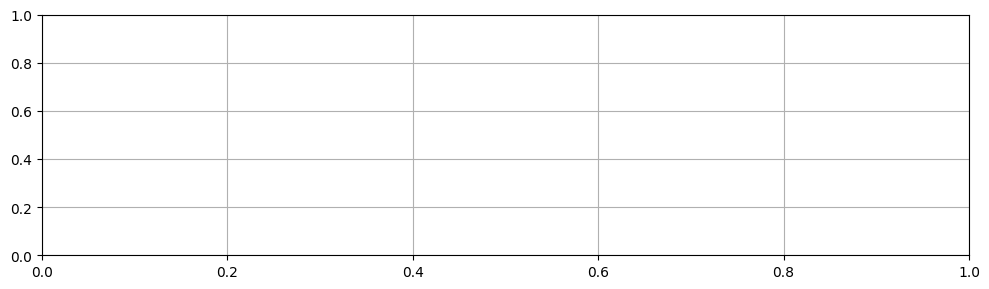

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

Converged!


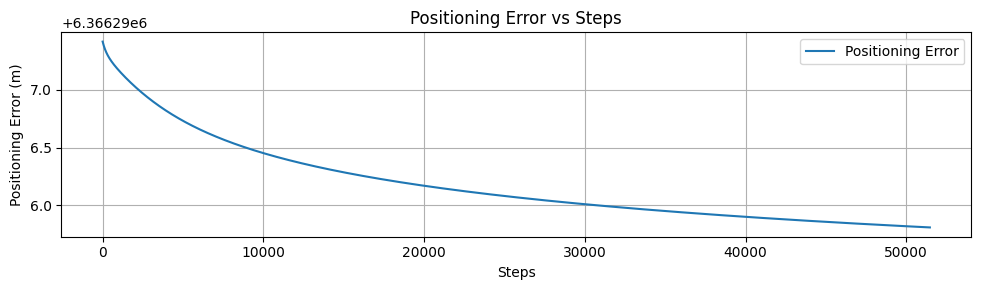

In [28]:
# Gradient descent algorithm with position tracking
def gradient_descent(pseudorange, s_pos, learning_rate=0.0001, max_iters=100000, tolerance=1e-6):
    global arr_cost, arr_grad, arr_positions, steps_count
    arr_cost = []
    arr_grad = []
    arr_positions = []  # Initialize an array to track positions at each step
    steps_count = 0
    X = np.random.uniform(-1e-3, 1e-3, size=4)  # Initializing with small random values

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        grad = gradient(r_pos, cdT, s_pos, pseudorange)
        grad = np.clip(grad, -1e3, 1e3)  # Cliping gradients to prevent overflow

        # Check for NaN or Inf in gradients
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Iteration {iteration}: Gradient has NaN or Inf values. Stopping optimization.")
            break

        X_new = X - learning_rate * grad
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        arr_cost.append(current_cost)
        arr_grad.append(np.linalg.norm(grad))
        arr_positions.append(X[:3])

        if np.abs(new_cost - current_cost) < tolerance:
            steps_count = iteration
            print("Converged!")
            break

        X = X_new

    return X

# Run the gradient descent function with the normalized data
optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.0001)

# Calculate positioning errors at each step
arr_err = [np.linalg.norm(pos - GroundTruth) for pos in arr_positions]

# Plot positioning errors vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err, label='Positioning Error')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error (m)')
ax.set_title('Positioning Error vs Steps')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

# Comment on the pattern:
# The "Positioning Error vs Steps" plot shows a decreasing trend in positioning errors as the number
# of steps increases. This indicates that the gradient descent algorithm is improving the estimated position
# with each iteration. If the positioning errors decrease smoothly and level off towards the end, this
# suggests that the algorithm has converged to an optimal or near-optimal solution.


# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [31]:
# Set learning rate to 0.01
# re-initialize arrays and counters
learning_rate = 0.01
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Call the gradient descent function with the new learning rate
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=20000)  # Adjusted max_iters for lower learning rate

# Calculate the final position error
final_position_error_2 = np.linalg.norm(optimized_params_2[:3] - GroundTruth)

# Calculate the final cost value
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

# Calculate the final gradient values
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

# Print the metrics
print("Results with Learning Rate = 0.01")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Error (m):", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)



Converged!
Results with Learning Rate = 0.01
Optimized Parameters (x_r, y_r, z_r, cdT): [-0.95253225 -2.40266396  0.50460216 -3.06378663]
Final Position Error (m): 6366295.403785674
Number of Steps Taken for Convergence: 2280
Final Cost Value: 1.0093263688398255
Final Gradient Values: [ 0.00241436  0.00659629 -0.00298258  0.00645843]


In [32]:
#set learning rate to 0.001
#re-initialize arrays and counters
learning_rate = 0.001
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Call the gradient descent function with the new learning rate
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate, max_iters=30000)  # Increased max_iters for lower learning rate

# Calculate the final position error
final_position_error_3 = np.linalg.norm(optimized_params_3[:3] - GroundTruth)

# Calculate the final cost value
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

# Calculate the final gradient values
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

# Print the metrics
print("Results with Learning Rate = 0.001")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
print("Final Position Error (m):", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)


Converged!
Results with Learning Rate = 0.001
Optimized Parameters (x_r, y_r, z_r, cdT): [-0.90548836 -2.27363918  0.44610346 -2.93853925]
Final Position Error (m): 6366295.535370756
Number of Steps Taken for Convergence: 12178
Final Cost Value: 1.0132822024047288
Final Gradient Values: [ 0.00763209  0.0210169  -0.00955482  0.02021769]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1. When the learning rate was reduced from 0.01 to 0.001, the number of steps required for convergence increased significantly (from 2280 to 12178 steps). Additionally, the final cost value and gradient values also showed slight differences. Lower learning rates tend to yield more precise convergence but require more iterations, whereas higher learning rates converge faster but may not be as precise.

Q2. LSE (Least Squares Estimation) is a closed-form solution that directly computes the parameters that minimize the cost function, typically more efficient when applicable. In contrast, Gradient Descent is an iterative method that gradually minimizes the cost by updating parameters based on the gradient, which is more flexible but can be computationally intensive for large iterations, as observed in the results.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [4]:
!pip install ucimlrepo

In [8]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# TO DO: display sizes of X and y (1 mark)

data = phishing_websites.data.features  # Feature matrix X
target = phishing_websites.data.targets  # Target vector y

# Display dataset size
print("Data Shape:", data.shape)
print("Target Shape:", target.shape)


Data Shape: (11055, 30)
Target Shape: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

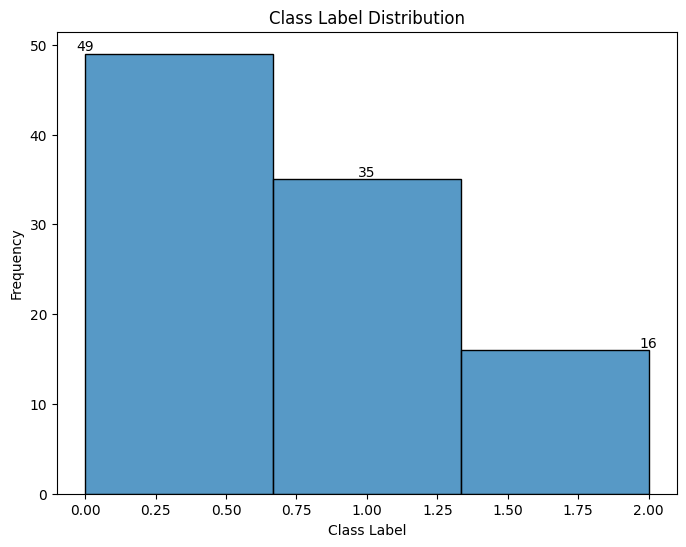

In [10]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming `y` is your target variable with class labels
# Replace this example with your actual `y` data
# Example placeholder data
y = np.random.choice([0, 1, 2], size=100, p=[0.5, 0.3, 0.2])

# Calculate class distribution
class_counts = np.bincount(y) if np.issubdtype(y.dtype, np.integer) else pd.Series(y).value_counts().sort_index()
class_labels = np.arange(len(class_counts))

# Plotting the histogram with counts above each bin
plt.figure(figsize=(8, 6))
sns.histplot(y, bins=len(class_counts), kde=False)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class Label Distribution")

# Annotate counts on top of each bar
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.show()


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [12]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

# Assuming `X` is the feature matrix and `y` is the target vector from the dataset
# Replace these placeholders with your actual data if available

# Create a smaller dataset with 3% of the data
X = data  # Assuming 'data' is your feature matrix
y = target['result'].values  # Assuming 'target' is your target vector and 'result' is the target column


# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)

print("X_small size:", X_small.shape)
print("y_small size:", y_small.shape)



X_small size: (331, 30)
y_small size: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn

2. Instantiate model `LogisticRegression(max_iter=2000)

3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [16]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Assuming X, y, X_small, and y_small are already defined in your notebook

# Step 3: Instantiate the Logistic Regression model
model = LogisticRegression(max_iter=2000, random_state=0)

# Function to train and test the model and return metrics
def train_and_evaluate(X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Calculate metrics
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    testing_accuracy = accuracy_score(y_test, model.predict(X_test))
    log_loss_value = log_loss(y_test, model.predict_proba(X_test))

    return len(X), len(X_train), len(X_test), training_accuracy, testing_accuracy, log_loss_value

# Step 4: Test Model on three datasets
results = {
    "Data size": [],
    "Training samples": [],
    "Testing samples": [],
    "Training accuracy": [],
    "Testing accuracy": [],
    "Log loss": []
}

# Dataset 1: Full X and y
data_size, train_samples, test_samples, train_acc, test_acc, loss = train_and_evaluate(X, y)
results["Data size"].append(data_size)
results["Training samples"].append(train_samples)
results["Testing samples"].append(test_samples)
results["Training accuracy"].append(train_acc)
results["Testing accuracy"].append(test_acc)
results["Log loss"].append(loss)

# Dataset 2: First two columns of X and y
data_size, train_samples, test_samples, train_acc, test_acc, loss = train_and_evaluate(X.iloc[:, :2], y)
results["Data size"].append(data_size)
results["Training samples"].append(train_samples)
results["Testing samples"].append(test_samples)
results["Training accuracy"].append(train_acc)
results["Testing accuracy"].append(test_acc)
results["Log loss"].append(loss)

# Dataset 3: X_small and y_small
data_size, train_samples, test_samples, train_acc, test_acc, loss = train_and_evaluate(X_small, y_small)
results["Data size"].append(data_size)
results["Training samples"].append(train_samples)
results["Testing samples"].append(test_samples)
results["Training accuracy"].append(train_acc)
results["Testing accuracy"].append(test_acc)
results["Log loss"].append(loss)

# Step 5.1: Visualize Results
results_df = pd.DataFrame(results)
print(results_df)


   Data size  Training samples  Testing samples  Training accuracy  \
0      11055              7738             3317           0.932282   
1      11055              7738             3317           0.562807   
2        331               231              100           0.943723   

   Testing accuracy  Log loss  
0          0.922822  0.190326  
1          0.556828  0.683573  
2          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [17]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 5.2: Visualize Classification Errors
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model to the full dataset (X and y)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


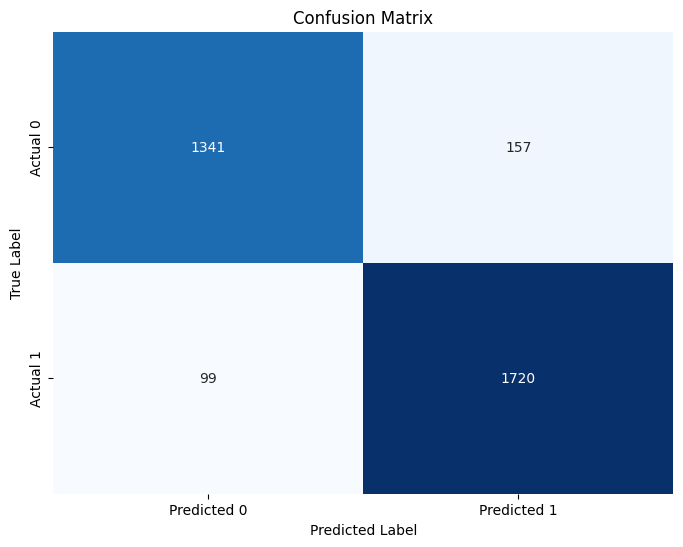

Text(113.9222222222222, 0.5, 'true value')

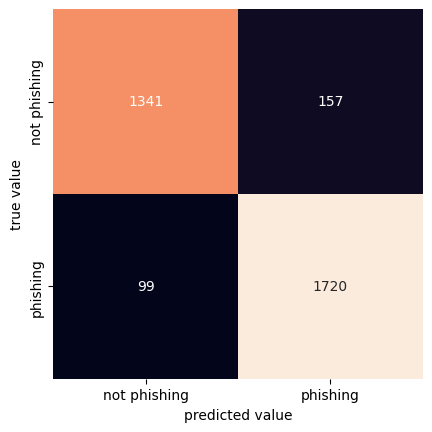

In [21]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [20]:
# TO DO: Print classification report (2 marks)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE
1. The output does not directly indicate class imbalance, but lower testing accuracy in some cases may suggest it. Imbalanced data typically impacts performance, especially on minority classes.

2. Case 1 (Full X and y): High training (93.2%) and testing accuracy (92.3%) indicate no significant overfitting.

  Case 2 (First two columns of X and y): Lower training (56.3%) and testing accuracy (55.7%) suggest underfitting due to limited features.

  Case 3 (X_small and y_small): High training (94.4%) and testing accuracy (91%) show a good fit without much overfitting.

3. With more data (Case 1), both training (93.2%) and testing accuracy (92.3%) are higher. Reducing features (Case 2) and data size (Case 3) decreases these accuracies, with Case 2 showing the lowest performance.

4. False Positive: Predicting a positive class incorrectly.

  False Negative: Predicting a negative class incorrectly.

  Depending on the context, a false negative could be worse (e.g., missing a diagnosis).

5. Maximizing recall would be ideal if false negatives are worse. Setting class_weight='balanced' or adjusting thresholds could help prioritize recall.

6. Case 1: Low log loss (0.190) reflects a confident model with sufficient data.

  Case 2: Higher log loss (0.684) suggests weaker predictions due to limited features.

  Case 3: Moderate log loss (0.200) indicates a confident model, but fewer data points may limit generalization.

​The differences in log loss across the cases are likely caused by the amount of data and number of features available for training.
